This notebook shows how to initialize and use the LatentVAE class.

In [1]:
from src.models.latent_models import LatentVQVAE
import yaml

In [2]:
# Configuration for the model
model_config_path = "../models/latent_vqvae/configs/sd35m_to_512d.yaml"

# Load model config
with open(model_config_path, "r") as f:
    model_config = yaml.safe_load(f)

ckpt_path = "../models/latent_vqvae/version_3/checkpoints/last.ckpt"

# Initialize model
latent_vqvae = LatentVQVAE(
    ddconfig=model_config["ddconfig"],
    lossconfig=model_config["lossconfig"],
    n_embed=model_config["embedconfig"]["n_embed"],
    embed_dim=model_config["embedconfig"]["embed_dim"],
    ckpt_path=ckpt_path,
    monitor="val_total_loss",
)

latent_vqvae.eval()
latent_vqvae

making attention of type 'none' with 128 in_channels
Working with z of shape (1, 8, 8, 8) = 512 dimensions.
making attention of type 'none' with 128 in_channels
Restored from ../models/latent_vqvae/version_3/checkpoints/last.ckpt with 0 missing and 183 unexpected keys


LatentVQVAE(
  (encoder): Encoder(
    (conv_in): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupN

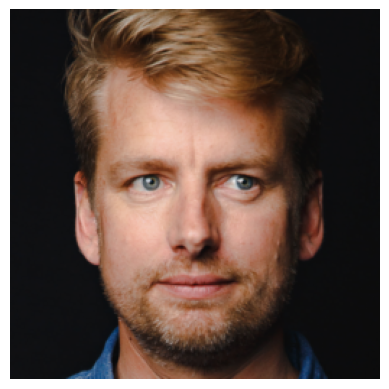

Image shape: torch.Size([1, 3, 256, 256])


In [3]:
# Load one example image
import torch
IMAGE_TENSOR_PATH = "../data/ffhq/pt_images/65432.pt" #54321.pt

img_tensor = torch.load(IMAGE_TENSOR_PATH)

# Add batch dimension: Change from (C, H, W) to (B, C, H, W)
img_tensor = img_tensor.unsqueeze(0)

# Show the image
import matplotlib.pyplot as plt
import numpy as np
img = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow((img + 1) / 2)
plt.axis('off')
plt.show()
print("Image shape:", img_tensor.shape)

In [4]:
# Load Stable Diffusion VAE model
from diffusers import AutoencoderKL

sd_vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="vae")
sd_vae.eval()

2025-04-19 23:19:51.992175: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 23:19:52.009325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745097592.023265  619663 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745097592.027505  619663 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745097592.041097  619663 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [5]:
# Encode the image using the Stable Diffusion VAE
sd_latent = sd_vae.encode(img_tensor).latent_dist.sample()

print("SD Latent shape:", sd_latent.shape)
print(f"Min: {sd_latent.min()}, Max: {sd_latent.max()}, Mean: {sd_latent.mean()}, Std: {sd_latent.std()}")

SD Latent shape: torch.Size([1, 16, 32, 32])
Min: -2.5313642024993896, Max: 1.7695146799087524, Mean: -0.08659172803163528, Std: 0.7712002396583557


In [6]:
# Encode the latent using the LatentVAE
latent = latent_vqvae.encode(sd_latent)[0]

print("Latent shape:", latent.shape)
print(f"Min: {latent.min()}, Max: {latent.max()}, Mean: {latent.mean()}, Std: {latent.std()}")

Latent shape: torch.Size([1, 8, 8, 8])
Min: -0.5858070850372314, Max: 0.4570755660533905, Mean: -0.09066155552864075, Std: 0.23217403888702393


In [7]:
# Decode the latent using the LatentVAE
recon = latent_vqvae.decode(latent)

print("Recon shape:", recon.shape)
print(f"Min: {recon.min()}, Max: {recon.max()}, Mean: {recon.mean()}, Std: {recon.std()}")

Recon shape: torch.Size([1, 16, 32, 32])
Min: -2.1427419185638428, Max: 1.5316308736801147, Mean: -0.07408760488033295, Std: 0.7662680149078369


In [8]:
# Decode the latent using the Stable Diffusion VAE
sd_recon = sd_vae.decode(recon).sample

print("SD Recon shape:", sd_recon.shape)
print(f"Min: {sd_recon.min()}, Max: {sd_recon.max()}, Mean: {sd_recon.mean()}, Std: {sd_recon.std()}")

SD Recon shape: torch.Size([1, 3, 256, 256])
Min: -1.0144109725952148, Max: 1.0173544883728027, Mean: -0.48089244961738586, Std: 0.5068287253379822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0072054863..1.0086772].


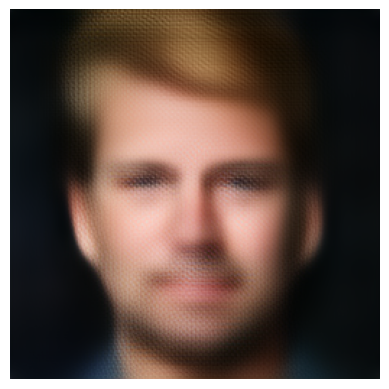

In [9]:
# Show the recon image
recon_img = sd_recon.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
plt.imshow((recon_img + 1) / 2)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0072054863..1.0086772].


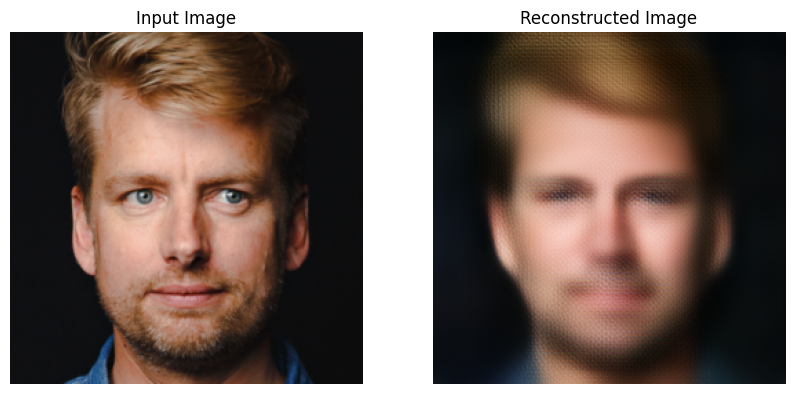

In [10]:
# plot input and recon next to each other
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow((img + 1) / 2)
ax[0].set_title("Input Image")
ax[0].axis('off')
ax[1].imshow((recon_img + 1) / 2)
ax[1].set_title("Reconstructed Image")
ax[1].axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028271258..0.97109675].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05302012..1.0527415].


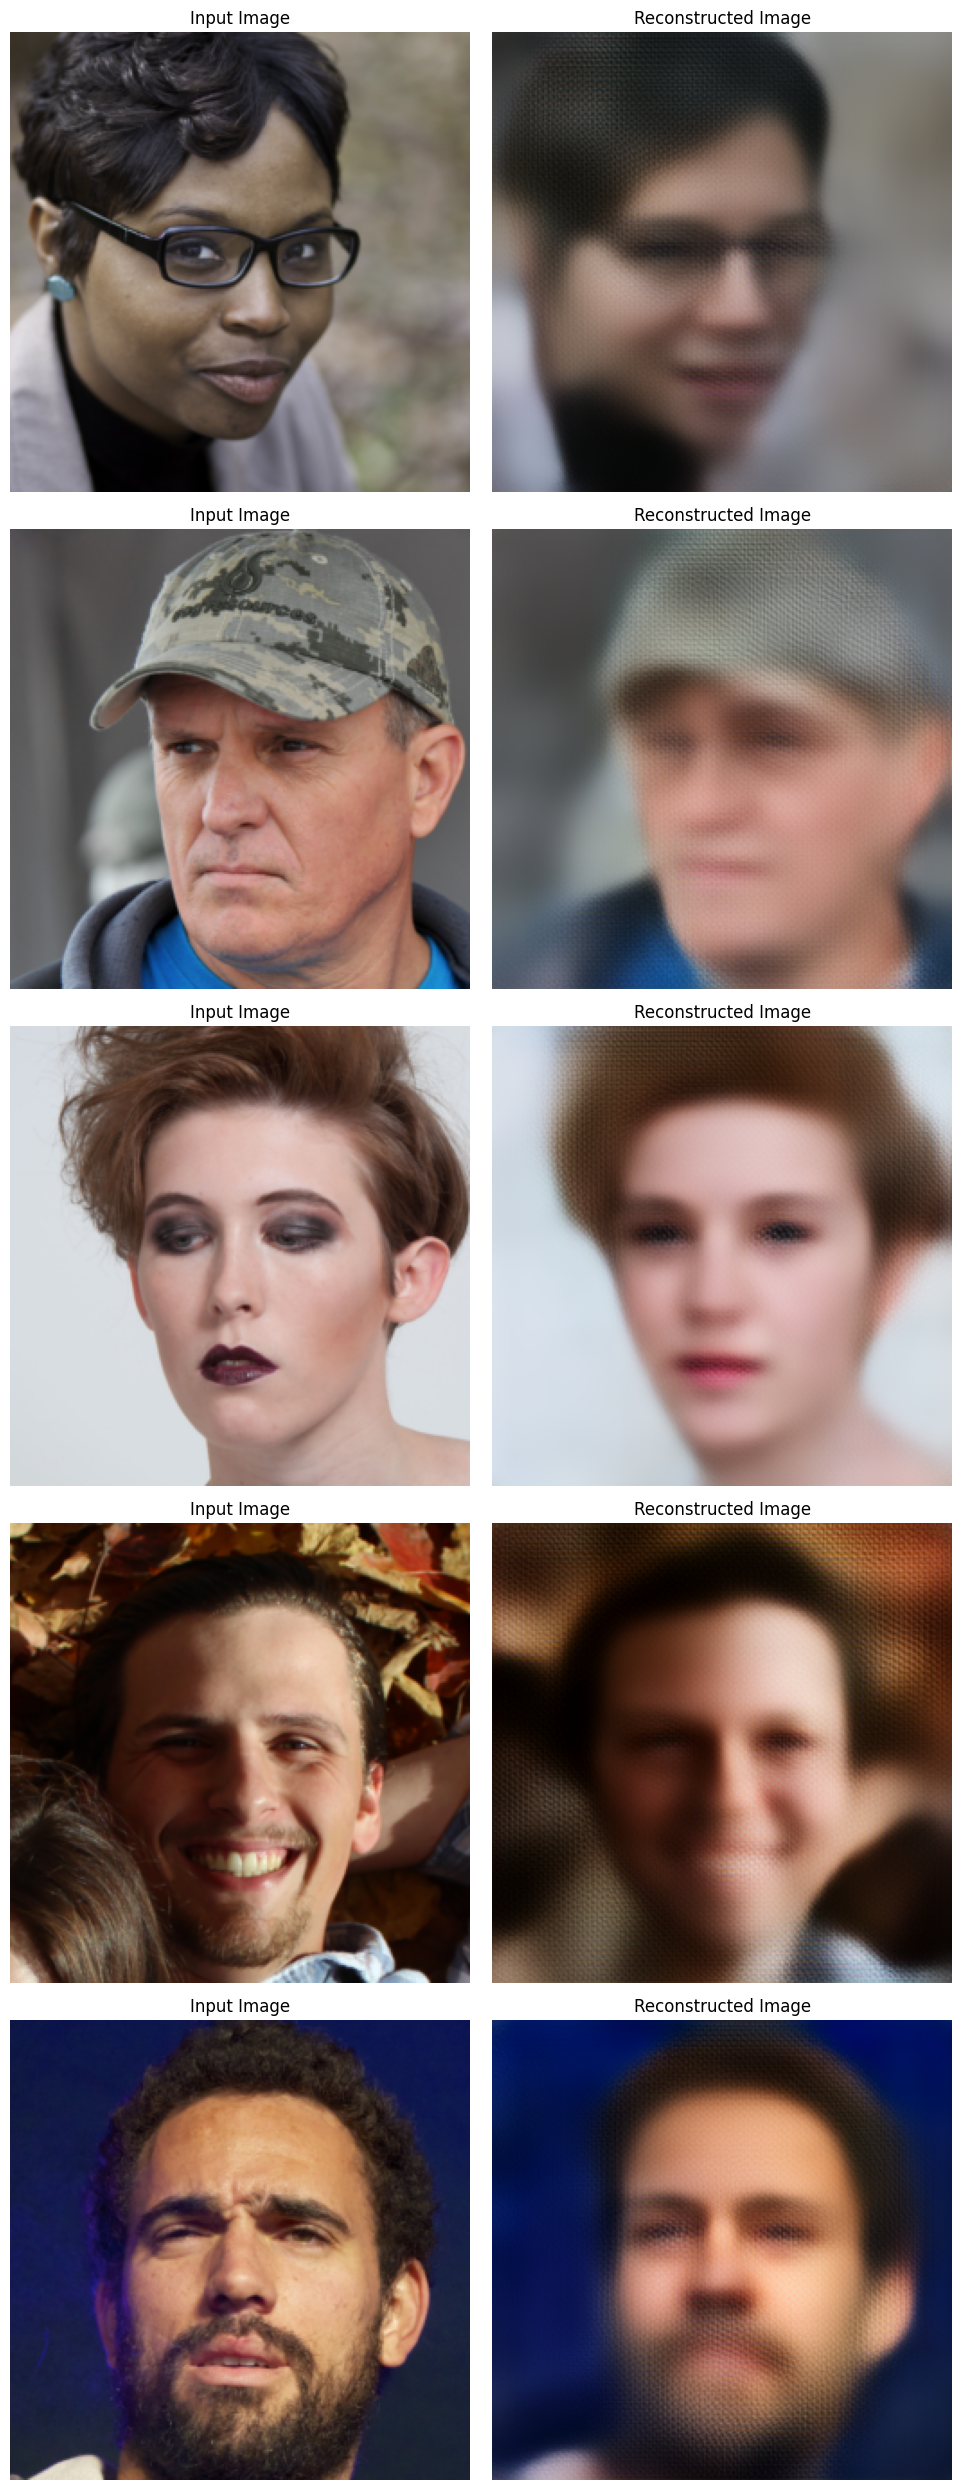

In [11]:
# plot 5 random inputs and recons next to each other
import os
import glob
import random
# Load the images from the folder
IMAGE_FOLDER = "../data/ffhq/pt_images/"
IMAGE_TENSOR_PATHS = glob.glob(os.path.join(IMAGE_FOLDER, "*.pt"))
# Select 5 random images
random.seed(42)
random.shuffle(IMAGE_TENSOR_PATHS)
selected_paths = IMAGE_TENSOR_PATHS[:5]
# Initialize lists to store images and reconstructions
input_images = []
reconstructed_images = []
# Loop through the selected images
for path in selected_paths:
    # Load the image
    img_tensor = torch.load(path)
    # Add batch dimension: Change from (C, H, W) to (B, C, H, W)
    img_tensor = img_tensor.unsqueeze(0)
    # Encode the image using the Stable Diffusion VAE
    sd_latent = sd_vae.encode(img_tensor).latent_dist.sample()
    # Encode the latent using the LatentVQVAE
    latent = latent_vqvae.encode(sd_latent)[0]
    # Decode the latent using the LatentVQVAE
    recon = latent_vqvae.decode(latent)
    # Decode the latent using the Stable Diffusion VAE
    sd_recon = sd_vae.decode(recon).sample
    # Store the images
    input_images.append(img_tensor.squeeze(0).permute(1, 2, 0).numpy())
    reconstructed_images.append(sd_recon.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
# Plot the input and reconstructed images
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
for i in range(5):
    ax[i, 0].imshow((input_images[i] + 1) / 2)
    ax[i, 0].set_title("Input Image")
    ax[i, 0].axis('off')
    ax[i, 1].imshow((reconstructed_images[i] + 1) / 2)
    ax[i, 1].set_title("Reconstructed Image")
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [76]:
# Find out how many unique latent embeddings are actually used
import os
import glob
import random
from tqdm import tqdm
# Load the images from the folder
IMAGE_FOLDER = "../data/ffhq/pt_images/"
IMAGE_TENSOR_PATHS = glob.glob(os.path.join(IMAGE_FOLDER, "*.pt"))
# Select 10 random images
random.seed(42)
random.shuffle(IMAGE_TENSOR_PATHS)
selected_paths = IMAGE_TENSOR_PATHS[:20]
# Initialize lists to store images and reconstructions
indices = []
# Loop through the selected images
for path in tqdm(selected_paths):
    # Load the image
    img_tensor = torch.load(path)
    # Add batch dimension: Change from (C, H, W) to (B, C, H, W)
    img_tensor = img_tensor.unsqueeze(0)
    # Encode the image using the Stable Diffusion VAE
    sd_latent = sd_vae.encode(img_tensor).latent_dist.sample()
    # Encode the latent using the LatentVQVAE
    latent, _, info = latent_vqvae.encode(sd_latent)
    # Store the indices
    indices.append(info[2].cpu())

# Unique indices
unique_indices = torch.unique(torch.cat(indices))
print(f"Number of unique latent vectors used: {unique_indices.numel()}/{latent_vqvae.n_embed}")

100%|██████████| 20/20 [01:21<00:00,  4.09s/it]

Number of unique latent vectors used: 288/1024
